In [1]:
import numpy as np
import pandas
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pickle
import matplotlib.pyplot as plt

## Constants

In [2]:
# file_path = "/nfs/lab/varpred/Final_Results/final_matrices/"
file_path = "./"
# t1d_mat = file_path + "T1D_final_short.bed"
t1d_mat = file_path + "t1d_final_short_after_loci_filtering.bed"
# t2d_mat = file_path + "T2D_final_short.bed"
t2d_mat = file_path + "t2d_final_short_after_loci_filtering.bed"
topmed_mat = file_path + "topmed_final.bed"
proba_threshold_high = 0.8
proba_threshold_low = 0.000005

# Data Ingestion

In [16]:
t1d_data = pandas.read_csv(t1d_mat, sep='\s+')
t2d_data = pandas.read_csv(t2d_mat, sep=' ')
# topmed_data = pandas.read_csv(topmed_mat, sep=' ')

t1d_labels = t1d_data["Probability"]
t1d_data = t1d_data.drop(['VarID', 'Probability'], axis=1)
t2d_labels = t2d_data["Probability"]
t2d_data = t2d_data.drop(['VarID', 'Probability'], axis=1)
# topmed_labels = topmed_data["Probability"]
# topmed_data = topmed_data.drop(['VarID', 'Probability'], axis=1)

# Label Propagation

In [7]:
label_prop_model = LabelPropagation()
# label_prop_model.fit(data, labels)

In [ ]:
pickle.dump(label_prop_model, open(f"./models/label_prop_model_thresh_{proba_threshold}", 'wb'))

# Label Spreading

In [8]:
label_spread_model = LabelSpreading(alpha=(proba_threshold_high))
label_spread_knn = LabelSpreading(alpha=(1-proba_threshold_high), kernel="knn")
# label_spread_model.fit(data, labels)

In [26]:
pickle.dump(label_spread_model, open(f"./models/label_spread_model_thresh_{proba_threshold}", 'wb'))

# Experimenting

In [33]:
# known_data_bool = labels != -1
# all_data = data.copy(deep=True)
# all_data.insert(len(all_data.columns), 'label', labels)
# all_data.insert(len(all_data.columns), 'known', known_data_bool)
# all_known_data = all_data[all_data.known == True]
# all_unknown_data = all_data[all_data.known == False]
# known_data = all_known_data.drop(['label', 'known'], axis=1)
# known_labels = all_known_data['label']
# unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
# unknown_labels = all_unknown_data['label']

# known_data_bool = t1d_peak_labels != -1
# all_data = t1d_peaks.copy(deep=True)
# all_data.insert(len(all_data.columns), 'label', t1d_peak_labels)
# all_data.insert(len(all_data.columns), 'known', known_data_bool)
# all_known_data = all_data[all_data.known == True]
# all_unknown_data = all_data[all_data.known == False]
# known_data = all_known_data.drop(['label', 'known'], axis=1)
# known_labels = all_known_data['label']
# unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
# unknown_labels = all_unknown_data['label']

def sort_data(data, labels):
    known_data_bool = labels != -1
    all_data = data.copy(deep=True)
    all_data.insert(len(all_data.columns), 'label', labels)
    all_data.insert(len(all_data.columns), 'known', known_data_bool)
    all_known_data = all_data[all_data.known == True]
    all_unknown_data = all_data[all_data.known == False]
    known_data = all_known_data.drop(['label', 'known'], axis=1)
    known_labels = all_known_data['label']
    unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
    unknown_labels = all_unknown_data['label']
    
    return all_known_data, known_data, known_labels, unknown_data, unknown_labels

all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(t1d_peaks, t1d_peak_labels)

In [34]:
print('Num unknown:', len(unknown_labels))
print('Num negative:', len(known_labels[known_labels == 0]))
print('Num positive:', len(known_labels[known_labels == 1]))

Num unknown: 4479
Num negative: 4661
Num positive: 4238


In [35]:
def create_splitter(all_known_data, unknown_data):
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(all_known_data)

    def custom_splitter(splits):
        for train_index, test_index in splits:
            train_index = np.append(train_index, list(unknown_data.index.values))
            yield train_index, test_index
            
    return splits, custom_splitter

create_splitter(all_known_data, unknown_data)

In [54]:
cv_score = cross_val_score(label_prop_model, t1d_peaks, y=t1d_peak_labels, cv=custom_splitter(splits), verbose=1, n_jobs=4)

<class 'generator'>
11089
1716 573
12805 573
1716 573
12805 573
1716 573
12805 573
1716 573
12805 573
1716 573
12805 573


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.0min finished


In [55]:
cv_score

array([0.09773124, 0.09773124, 0.11343805, 0.12914485, 0.10994764])

In [36]:
cv_score = cross_val_score(label_spread_knn, t1d_peaks, y=t1d_peak_labels, cv=custom_splitter(splits), verbose=1, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=Conve

In [37]:
cv_score

array([0.38831461, 0.38876404, 0.36      , 0.36359551, 0.37168539])

# Automating Experiments

## Data Ingestion

In [11]:
# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')

# Splitting labels and data
t1d_labels_raw = t1d_data_raw["Probability"]
t1d_data_raw = t1d_data_raw.drop(['Locus', 'VarID', 'Probability'], axis=1)

# Filtering out variants with all 0s
print("Originally", len(t1d_data_raw), "variants.", "Filtering out", len(t1d_data_raw) - len(t1d_data_raw[(t1d_data_raw.T != 0).any()]), "variants; left with", len(t1d_data_raw[(t1d_data_raw.T != 0).any()]))

t1d_data = t1d_data_raw[(t1d_data_raw.T != 0).any()]  # Only non-zero variants
t1d_labels = t1d_labels_raw[t1d_labels_raw.index.isin(t1d_data.index)]  # Get matching labels

# Resetting index for splitting
t1d_data = t1d_data.reset_index(drop=True)
t1d_labels = t1d_labels.reset_index(drop=True)

Originally 12380 variants. Filtering out 0 variants; left with 12380


In [12]:
# Removing imbalance columns
t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'imbal' in col])

## Label Spreading Model Tests

In [18]:
# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1
    
# Split unknown and known data
def sort_data(data, labels):
    known_data_bool = labels != -1
    all_data = data.copy(deep=True)
    all_data.insert(len(all_data.columns), 'label', labels)
    all_data.insert(len(all_data.columns), 'known', known_data_bool)
    all_known_data = all_data[all_data.known == True]
    all_unknown_data = all_data[all_data.known == False]
    known_data = all_known_data.drop(['label', 'known'], axis=1)
    known_labels = all_known_data['label']
    unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
    unknown_labels = all_unknown_data['label']
    
    return all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels


def create_splitter(all_known_data, unknown_data):
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(all_known_data)

    def custom_splitter(splits):
        for train_index, test_index in splits:
            train_index = np.append(train_index, list(unknown_data.index.values))
            yield train_index, test_index
            
    return splits, custom_splitter


def perform_cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    splits, custom_splitter = create_splitter(all_known_data, unknown_data)
    cv_score = cross_val_score(model, data, y=labels, cv=custom_splitter(splits), verbose=1, n_jobs=1)
    return np.mean(cv_score)

def cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(known_data)
    
    total_acc_score = 0
    total_prec_score = 0
    total_rec_score = 0
    total_fp_score = 0
    total_tp_score = 0
    total_tn_score = 0
    total_fn_score = 0
    num = 0
    for train_idx, test_idx in splits:
        train_data = known_data.iloc[train_idx].append(unknown_data)
        test_data = known_data.iloc[test_idx]
        train_labels = known_labels.iloc[train_idx].append(unknown_labels)
        test_labels = known_labels.iloc[test_idx]

        model.fit(train_data, train_labels)

        # Predict on test
        pred_labels = model.predict(test_data)

        # Measure accuracy
        acc = accuracy_score(pred_labels, test_labels)
        prec = precision_score(pred_labels, test_labels)
        rec = recall_score(pred_labels, test_labels)
        total_acc_score += acc
        total_prec_score += prec
        total_rec_score += rec
        tn, fp, fn, tp = confusion_matrix(pred_labels, test_labels).ravel()
        total_fp_score += (fp / (fp + tp))
        total_tp_score += (tp / (fp + tp))
        total_fn_score += (fn / (fn + tn))
        total_tn_score += (tn / (fn + tn))
        num += 1
        break

    print("Avg accuracy, precision, recall:", total_acc_score / num, total_prec_score / num, total_rec_score / num)
    print("fp, tp, tn, fn:", total_fp_score / num, total_tp_score / num, total_tn_score / num, total_fn_score / num)
    return total_acc_score / num, total_prec_score / num, total_rec_score / num, total_fp_score / num, total_tp_score / num, total_fn_score / num, total_tn_score / num

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# high_prob_thresholds = [0.01, 0.001, 0.0001]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
high_prob_thresholds = [0.001]
low_prob_thresholds = [0.000005]
# low_prob_thresholds = [0.00002, 0.000025, 0.00003]
# kernels = ['knn', 'rbf']
kernels = ['rbf']
# gammas = [30, 25, 20, 15, 10, 5]
# gammas = [25, 20, 15]
gammas = [20]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
# n_neighbors = [8, 7, 6]
n_neighbors = [7]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Kernel",
    "alpha",
    "gamma",
    "n_neighbors",
    "Average Accuracy Score",
    "Average Precision Score",
    "Average Recall Score",
    "Avg False Positives",
    "Avg True Positives",
    "Avg False Negatives", 
    "Average True Negatives"
]
res = pandas.DataFrame(columns=res_columns)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        # Label points based on prob thresholds
        print("high: ", prob_thresh_high, "low", prob_thresh_low, end=':')
        print("Positive", len(t1d_labels[t1d_labels > prob_thresh_high]), end='; ')
        print("Negative", len(t1d_labels[t1d_labels < prob_thresh_low]), end='; ')
        print("Unlabelled", len(t1d_labels[(t1d_labels <= prob_thresh_high) & (t1d_labels >= prob_thresh_low)]), end='; ')
        print("")
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        alphas += [prob_thresh_high]
        for alpha in alphas:
            for kernel in kernels:
                models = []
                if kernel == 'rbf':
                    for gamma in gammas:
                        model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma)
                        norm_model = make_pipeline(MinMaxScaler(), model)
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, gamma, "N/A", acc, prec, rec, fp, tp, fn, tn]
                elif kernel == 'knn':
                    for neighbors in n_neighbors:
                        model = LabelSpreading(kernel="knn", alpha=alpha, n_neighbors=neighbors)
                        norm_model = make_pipeline(Normalizer(), model)
                        acc, prec, rec, fp, tp, fn, tn = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, "N/A", neighbors, acc, prec, rec, fp, tp, fn, tn]

                else:
                    print("Error; invalid kernel")
                    continue

res.to_csv("./Results/test_tp_fp_acc.csv")           

high:  0.001 low 5e-06:Positive 1930; Negative 246; Unlabelled 10204; 
Avg accuracy, precision, recall: 0.875 0.9621848739495799 0.9015748031496063
fp, tp, tn, fn: 0.037815126050420166 0.9621848739495799 0.2647058823529412 0.7352941176470589
Avg accuracy, precision, recall: 0.8731617647058824 0.9600840336134454 0.9013806706114399
fp, tp, tn, fn: 0.03991596638655462 0.9600840336134454 0.2647058823529412 0.7352941176470589
Avg accuracy, precision, recall: 0.8694852941176471 0.957983193277311 0.8994082840236687
fp, tp, tn, fn: 0.04201680672268908 0.957983193277311 0.25 0.75


In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

kernels = ['knn', 'rbf']
# gammas = [30, 25, 20, 15, 10, 5]
gammas = [25, 20, 15]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
n_neighbors = [8, 7, 6]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

hthresh = 0.01
lthresh = 0.000007
pca_model = PCA(n_components = 5)
t1d_data_pca = pca_model.fit_transform(t1d_data)

model = LabelSpreading(kernel='rbf', alpha=0.2, gamma=20)
norm_model = make_pipeline(MinMaxScaler(), model)
score = perform_cv(norm_model, t1d_data_pca, t1d_labels_thresh)
print("rbf score", score)

model = LabelSpreading(kernel="knn", alpha=0.2, n_neighbors=8)
norm_model = make_pipeline(Normalizer(), model)
score = perform_cv(norm_model, t1d_data_pca, t1d_labels_thresh)
print('knn score', score)

[[ -6759.33899192 -10743.136265    10161.05226608  -1304.8012852
    -479.3257097 ]
 [ -6762.41304351 -10737.86177824  10167.62264208  -1305.6679956
    -470.29424286]
 [ -6510.53688799 -11208.01372634   9700.00032886  -1231.36814599
     -92.48422542]
 ...
 [  9739.20867087   8579.13541843    528.29563872   -529.07715087
   -1031.52022714]
 [  9740.06878706   8577.73177163    526.32778368   -528.35154777
   -1034.27356135]
 [  9633.07625187   8642.12669551    628.62543513   -627.64055969
    -900.55930358]]


AttributeError: 'numpy.ndarray' object has no attribute 'insert'

In [3]:
t1d_res = pandas.read_csv('./Results/label_spreading_res_normalized_fixed_cv.csv')
t2d_res = pandas.read_csv('./Results/t2d_normalized_label_spreading.csv')

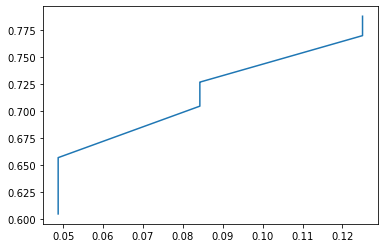

In [9]:
x = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

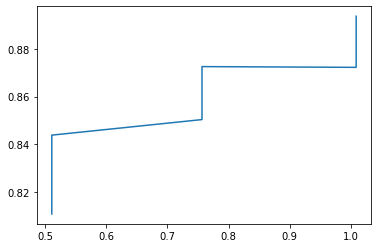

In [10]:
x = t2d_res["Labelled/Unlabelled Ratio"]
y = t2d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

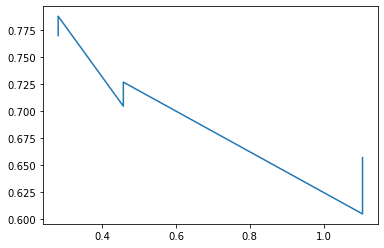

In [12]:
x = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

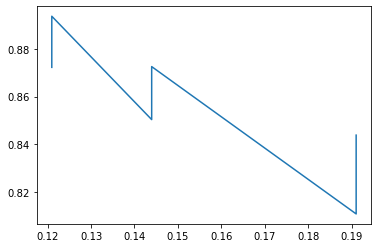

In [13]:
x = t2d_res["Pos/Neg ratio"]
y = t2d_res['Average Accuracy Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='label/unlabel ratio')

In [3]:
t1d_res = pandas.read_csv('./Results/t1d_ls_precision_accuracy_filtered.csv')

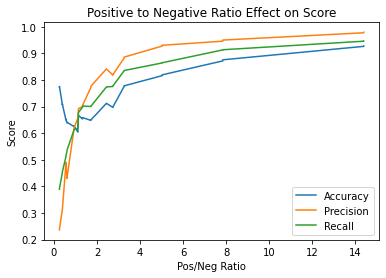

In [14]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

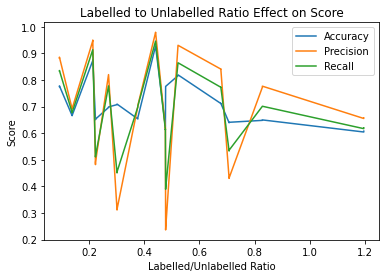

In [15]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Average Accuracy Score']
y2 = t1d_res['Average Precision Score']
y3 = t1d_res['Average Recall Score']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='Accuracy')
plt.plot(x2, y2, label='Precision')
plt.plot(x3, y3, label='Recall')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

In [6]:
t1d_res = pandas.read_csv('./Results/t1d_ls_precision_accuracy_filtered_tp_fp.csv')

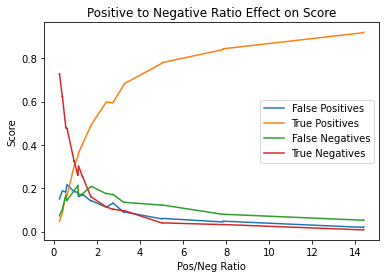

In [4]:
x = t1d_res["Pos/Neg ratio"]
x2 = t1d_res["Pos/Neg ratio"]
x3 = t1d_res["Pos/Neg ratio"]
x4 = t1d_res["Pos/Neg ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Positive to Negative Ratio Effect on Score")
plt.xlabel("Pos/Neg Ratio")
plt.ylabel("Score")
plt.legend()

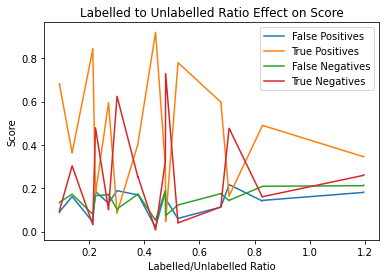

In [5]:
x = t1d_res["Labelled/Unlabelled Ratio"]
x2 = t1d_res["Labelled/Unlabelled Ratio"]
x3 = t1d_res["Labelled/Unlabelled Ratio"]
x4 = t1d_res["Labelled/Unlabelled Ratio"]
y = t1d_res['Avg False Positives']
y2 = t1d_res['Avg True Positives']
y3 = t1d_res['Avg False Negatives']
y4 = t1d_res['Average True Negatives']

zipped = zip(x, y)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x, y = [list(tuple) for tuple in tuples]

zipped = zip(x2, y2)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x2, y2 = [list(tuple) for tuple in tuples]

zipped = zip(x3, y3)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x3, y3 = [list(tuple) for tuple in tuples]

zipped = zip(x4, y4)
sortedlist = sorted(zipped)

tuples = zip(*sortedlist)
x4, y4 = [list(tuple) for tuple in tuples]

plt.plot(x, y, label='False Positives')
plt.plot(x2, y2, label='True Positives')
plt.plot(x3, y3, label='False Negatives')
plt.plot(x4, y4, label='True Negatives')
plt.title("Labelled to Unlabelled Ratio Effect on Score")
plt.xlabel("Labelled/Unlabelled Ratio")
plt.ylabel("Score")
plt.legend()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

high_prob_thresholds = [0.01, 0.001, 0.0001]
low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
# high_prob_thresholds = [0.01]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007]
# low_prob_thresholds = [0.00002, 0.000025, 0.00003]
# kernels = ['knn', 'rbf']
kernels = ['rbf']
# gammas = [30, 25, 20, 15, 10, 5]
# gammas = [25, 20, 15]
gammas = [20]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
# n_neighbors = [8, 7, 6]
n_neighbors = [7]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Kernel",
    "alpha",
    "gamma",
    "n_neighbors",
    "Average Accuracy Score",
    "Average Precision Score",
    "Average Recall Score"
]
res = pandas.DataFrame(columns=res_columns)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        # Label points based on prob thresholds
        print("high: ", prob_thresh_high, "low", prob_thresh_low, end=':')
        print("Positive", len(t1d_labels[t1d_labels > prob_thresh_high]), end='; ')
        print("Negative", len(t1d_labels[t1d_labels < prob_thresh_low]), end='; ')
        print("Unlabelled", len(t1d_labels[(t1d_labels <= prob_thresh_high) & (t1d_labels >= prob_thresh_low)]), end='; ')
        print("")
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        alphas += [1 - prob_thresh_high]
        for alpha in alphas:
            for kernel in kernels:
                models = []
                if kernel == 'rbf':
                    for gamma in gammas:
                        model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma)
                        norm_model = make_pipeline(MinMaxScaler(), model)
                        acc, prec, rec = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, gamma, "N/A", acc, prec, rec]
                elif kernel == 'knn':
                    for neighbors in n_neighbors:
                        model = LabelSpreading(kernel="knn", alpha=alpha, n_neighbors=neighbors)
                        norm_model = make_pipeline(Normalizer(), model)
                        acc, prec, rec = cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, "N/A", neighbors, acc, prec, rec]

                else:
                    print("Error; invalid kernel")
                    continue

res.to_csv("./Results/t1d_ls_precision_accuracy_filtered.csv")           

In [8]:
t1d_res[t1d_res['Pos/Neg ratio'] > 10]

,Unnamed: 0,Positive Threshold,Negative Threshold,Num Positive Variants,Num Negative Variants,Num Unlabelled Variants,Pos/Neg ratio,Labelled/Unlabelled Ratio,Kernel,alpha,gamma,n_neighbors,Average Accuracy Score,Average Precision Score,Average Recall Score,Avg False Positives,Avg True Positives,Avg False Negatives,Average True Negatives
75,75,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.2000,20,NaN,0.926294,0.977300,0.946022,0.021331,0.917635,0.052376,0.008659
76,76,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.5000,20,NaN,0.926927,0.978200,0.945864,0.020486,0.918479,0.052587,0.008448
77,77,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
78,78,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
79,79,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
80,80,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
81,81,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9900,20,NaN,0.926927,0.978423,0.945668,0.020275,0.918691,0.052798,0.008237
82,82,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9990,20,NaN,0.927138,0.978648,0.945680,0.020063,0.918902,0.052798,0.008237
83,83,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9990,20,NaN,0.927138,0.978648,0.945680,0.020063,0.918902,0.052798,0.008237
84,84,0.0001,0.000005,3542,246,8592,14.398374,0.440875,rbf,0.9990,20,NaN,0.927138,0.978648,0.945680,0.020063,0.918902,0.052798,0.008237
